## Подготавливаем данные и смотрим что вообще имеем

In [1]:
import chess
import pandas as pd
import numpy as np
pd.set_option("max_colwidth", 999)

In [2]:
df = pd.read_csv('fens_training_set.csv')
df.head()

,fen,move
0,7k/5p1p/p2p1Pr1/1p4pQ/8/P1P5/2pr3P/2R2K2 w - - 0 1,h5f3
1,5r2/2p3k1/1p3pb1/p1pPr2p/2P1PRP1/3B1R2/PP4K1/8 w - - 0 1,g4h5
2,r2r2k1/p3bpp1/q2Bp2p/2pn4/2b1N1Q1/8/PPP2PPP/3RR1K1 w - - 0 1,d6e7
3,8/8/8/7K/1k6/8/6P1/8 w - - 0 1,g2g4
4,rnbqkb1r/pp3ppp/5n2/3p4/2pP4/3B1N2/PPP2PPP/RNBQ1RK1 w kq - 0 1,f1e1


In [3]:
board = chess.Board(df['fen'][0])

In [4]:
df['fen'][0]

'7k/5p1p/p2p1Pr1/1p4pQ/8/P1P5/2pr3P/2R2K2 w - - 0 1'

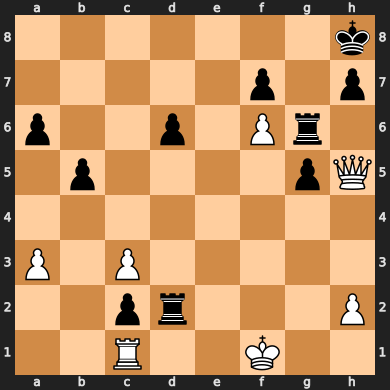

In [5]:
board

In [6]:
bad_string = []

In [7]:
for bd in df.index:
    curr_str = df.loc[bd]
    curr_board = chess.Board(curr_str['fen'])
    if curr_str['move'] not in list(map(str, curr_board.legal_moves)):
        bad_string.append(bd)

print(len(bad_string))


1


In [8]:
bad_string = bad_string[0]
board = chess.Board(df['fen'].loc[bad_string])
print(df['move'].loc[bad_string])

f1h1


In [9]:
df.drop(index=bad_string, inplace=True)

In [10]:
df.columns

Index(['fen', 'move'], dtype='object')

Подготовить все возможные ходы

In [11]:
board.has_kingside_castling_rights(chess.BLACK)

False

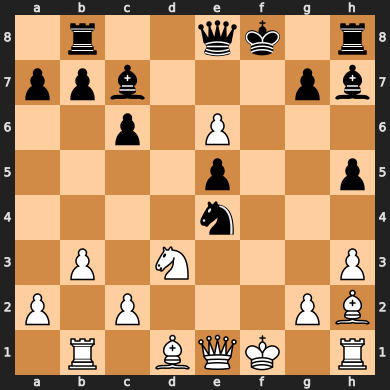

In [12]:
board

In [13]:
piece_to_plane = {
    (chess.PAWN, True):0, (chess.KNIGHT, True):1, (chess.BISHOP, True):2,
    (chess.ROOK, True):3, (chess.QUEEN, True):4, (chess.KING, True):5,
    (chess.PAWN, False):6, (chess.KNIGHT, False):7, (chess.BISHOP, False):8,
    (chess.ROOK, False):9, (chess.QUEEN, False):10, (chess.KING, False):11,
}

In [14]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [15]:
def board_to_tensor(board):
    planes = torch.zeros((19, 8, 8), dtype=torch.float32)
    # Слой - фигура определенного цвета
    for sq in chess.SQUARES:
        piece = board.piece_at(sq)
        if piece:
            plane = piece_to_plane[(piece.piece_type, piece.color)]
            r = 7 - chess.square_rank(sq)
            c = chess.square_file(sq)
            planes[plane, r, c] = 1.0
    # чей ход
    if (board.turn == chess.WHITE):
        planes[12, :, :] = 1.0
    # Рокировки
    planes[13,:,:] = 1.0 if board.has_kingside_castling_rights(chess.WHITE) else 0.0
    planes[14,:,:] = 1.0 if board.has_queenside_castling_rights(chess.WHITE) else 0.0
    planes[15,:,:] = 1.0 if board.has_kingside_castling_rights(chess.BLACK) else 0.0
    planes[16,:,:] = 1.0 if board.has_queenside_castling_rights(chess.BLACK) else 0.0
    # Взятие
    if board.ep_square is not None:
        r = 7 - chess.square_rank(board.ep_square)
        c = chess.square_file(board.ep_square)
        planes[17, r, c] = 1.0
    # ШАХ!
    planes[18, :, :] = 1.0 if board.is_check() else 0.0
    return planes


In [16]:
def index_to_move(idx):
    promo = idx%5
    tmp = idx//5
    frm = tmp//64
    to = tmp%64
    if promo == 0:
        return chess.Move(frm, to)
    else:
        promo_piece = {1 : chess.QUEEN, 2 : chess.ROOK, 3 : chess.BISHOP, 4 : chess.KNIGHT}[promo]
        return chess.Move(frm, to, promotion=promo_piece)

In [17]:
promo_map = {'q' : 1, 'r' : 2, 'b' : 3, 'n': 4}

def move_to_index(move):
    frm = move.from_square
    to = move.to_square
    promo = 0
    if (move.promotion):
        promo = promo_map[chess.piece_symbol(move.promotion).lower()]
        if move.promotion == chess.QUEEN : promo = 1
        elif move.promotion == chess.ROOK : promo = 2
        elif move.promotion == chess.BISHOP : promo = 3
        elif move.promotion == chess.KNIGHT: promo = 4
    return frm * 64 * 5 + to * 5 + promo

def legal_mask(board):
    mask = torch.zeros(64*64*5, dtype=torch.bool)
    for mv in board.legal_moves:
        idx = move_to_index(mv)
        mask[idx] = True
    return mask

In [18]:
for i in board.legal_moves:
    print(move_to_index(i))
    break

6260


In [19]:
df.reset_index(drop=True)
df.head()

,fen,move
0,7k/5p1p/p2p1Pr1/1p4pQ/8/P1P5/2pr3P/2R2K2 w - - 0 1,h5f3
1,5r2/2p3k1/1p3pb1/p1pPr2p/2P1PRP1/3B1R2/PP4K1/8 w - - 0 1,g4h5
2,r2r2k1/p3bpp1/q2Bp2p/2pn4/2b1N1Q1/8/PPP2PPP/3RR1K1 w - - 0 1,d6e7
3,8/8/8/7K/1k6/8/6P1/8 w - - 0 1,g2g4
4,rnbqkb1r/pp3ppp/5n2/3p4/2pP4/3B1N2/PPP2PPP/RNBQ1RK1 w kq - 0 1,f1e1


## Создаю датасет

In [20]:
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision
from torchvision.transforms import v2
V = 64*64*5
class ChessDataset(Dataset):
    def __init__(self, df, board_to_tensor, move_to_index):
        self.data = df
        self.board_to_tensor = board_to_tensor
        self.move_to_index = move_to_index

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = df.iloc[idx]
        fen = row['fen']
        uci = row['move']
        board = chess.Board(fen)
        planes = board_to_tensor(board)
        mv = chess.Move.from_uci(uci)
        target_idx = int(self.move_to_index(mv))
        legal_idx = np.fromiter((move_to_index(mv) for mv in board.legal_moves), dtype=np.int32)
        return planes, target_idx, legal_idx

In [21]:
def collate_build_mask(batch):
    B = len(batch)
    C = batch[0][0].shape
    planes_np = np.stack([item[0] for item in batch], axis=0, dtype=np.float32)
    targets = torch.tensor([int(item[1]) for item in batch], dtype=torch.int64)
    rows = []
    cols = []
    for i, item in enumerate(batch):
        idxs = item[2]
        rows.append(np.full(idxs.shape[0], i, dtype=np.int64))
        cols.append(idxs.astype(np.int64))
    rows = np.concatenate(rows)
    cols = np.concatenate(cols)
    legal_mask = torch.zeros((B, V), dtype=torch.bool)
    legal_mask[torch.from_numpy(rows), torch.from_numpy(cols)] = True
    planes_torch = torch.from_numpy(planes_np)
    return planes_torch, targets, legal_mask


In [22]:
ds = ChessDataset(df.head(), board_to_tensor, move_to_index)

In [23]:
dt = DataLoader(ds, batch_size=1, collate_fn=collate_build_mask, drop_last=True, pin_memory=True)

In [24]:
for planes, targets, legal_mask in dt:
        print("planes", planes.shape)        # (B,19,8,8)
        print("targets", targets.shape)      # (B,)
        print("legal_mask", legal_mask.shape) # (B,V)
        # переносим на GPU в training loop:
        planes = planes.to(device)
        targets = targets.to(device)
        legal_mask = legal_mask.to(device)
        break

planes torch.Size([1, 19, 8, 8])
targets torch.Size([1])
legal_mask torch.Size([1, 20480])


## Модель: простой resnet + маска

In [25]:
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
BIG_NEG = -1e9
class ChessModel(nn.Module):
    def __init__(self, in_channels=19, hidden =64, n_blocks=2, out=V):
        super().__init__()
        self.conv_in = nn.Conv2d(in_channels=in_channels, out_channels=hidden, kernel_size=3, padding=1, stride=1, dtype=torch.float32)
        self.bn_in = nn.BatchNorm2d(hidden)
        self.relu = nn.ReLU(inplace=True)
        self.blocks = nn.ModuleList()
        for _ in range(n_blocks):
            self.blocks.append(nn.Sequential(
                nn.Conv2d(hidden, hidden, kernel_size=3, padding=1, stride=1, dtype=torch.float32),
                nn.BatchNorm2d(hidden),
                nn.ReLU(inplace=True),
                nn.Conv2d(hidden, hidden, kernel_size=3, padding=1, stride=1, dtype=torch.float32),
                nn.BatchNorm2d(hidden)
            ))
        self.conv_head = nn.Conv2d(hidden, 64, kernel_size=1, dtype=torch.float32)
        self.dropout = nn.Dropout(0.35)
        self.fc = nn.Linear(64*8*8, out)

    def forward(self, x):
        # x : (B, C, 8, 8)
        x = self.relu(self.bn_in(self.conv_in(x)))
        for blk in self.blocks:
            res = x
            out = blk(x)
            x = self.relu(out + res)
        x = self.relu(self.conv_head(x))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        logits = self.fc(x)
        return logits


In [ ]:
# EPOCH = 100
train_loss = []
val_loss = []
val_acc = []
train_acc = []
from tqdm import tqdm

ds = ChessDataset(df, board_to_tensor, move_to_index)
train, test_set = random_split(ds, [0.8, 0.2])
train_set, val_set = random_split(train, [0.8, 0.2])
train_loader = DataLoader(train_set, batch_size=1, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)
model = ChessModel().to(device)
opt = AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)


In [27]:
print(next(model.parameters()).device)

cuda:0


In [28]:
print(len(train_set))
print(len(val_set))
print(len(test_set))

171872
42968
53709


### 15 эпох, метрики: top1, top3

In [29]:
EPOCH = 15
train_loss = []
val_loss = []
val_acc = []
train_acc = []
val_top3_acc_list = []
from tqdm import tqdm
best_top3_acc = 0.0
mean_val_loss = 0
BEST_MODEL_PATH = '.'
ds = ChessDataset(df, board_to_tensor, move_to_index)
train, test_set = random_split(ds, [0.7, 0.3])
train_set, val_set = random_split(train, [0.9, 0.1])
# train_set = ChessDataset(df[:500], board_to_tensor, move_to_index)
# val_set = ChessDataset(df[500: 551], board_to_tensor, move_to_index)
train_loader = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_build_mask)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False, collate_fn=collate_build_mask)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False, collate_fn=collate_build_mask, drop_last=True)
for epoch in range(EPOCH):
    running_train_loss = []
    model.train()
    true_answer = 0
    train_loop = tqdm(train_loader, leave=False)
    for planes, targets, legal_mask in train_loop:
        planes = planes.to(device, non_blocking=True).float()
        targets = targets.to(device, non_blocking=True)
        legal_mask = legal_mask.to(device, non_blocking=True)

        logits = model(planes)
        masked_logits = logits.masked_fill(~legal_mask, BIG_NEG)



        loss = F.cross_entropy(masked_logits, targets)
        opt.zero_grad()
        loss.backward()
        opt.step()


        running_train_loss.append(loss.item())
        true_answer += (masked_logits.argmax(dim=1) == targets).sum().item()
        mean_train_loss = np.sum(running_train_loss)/len(running_train_loss)
        train_loop.set_description(f'epoch {epoch + 1}/{EPOCH}, train_loss={mean_train_loss}')

    running_train_acc = true_answer/len(train_set)
    train_loss.append(mean_train_loss)
    train_acc.append(running_train_acc)

    correct_top3_val = 0
    model.eval()
    val_loop = tqdm(val_loader, leave=False)
    with torch.no_grad():
        running_val_loss = []
        true_answer = 0
        for planes, targets, legal_mask in val_loop:

            planes = planes.to(device, non_blocking=True).float()
            targets = targets.to(device, non_blocking=True)
            legal_mask = legal_mask.to(device, non_blocking=True)

            logits = model(planes)
            masked_logits = logits.masked_fill(~legal_mask, BIG_NEG)

            loss = F.cross_entropy(masked_logits, targets)
            running_val_loss.append(loss.item())

            top3_pred = masked_logits.topk(3, dim=1).indices  # (B, 3)
            correct_top3 = (top3_pred == targets.unsqueeze(1)).any(dim=1)
            correct_top3_val += correct_top3.sum().item()

            true_answer += (masked_logits.argmax(dim=1) == targets).sum().item()
            mean_val_loss = sum(running_val_loss)/len(running_val_loss)
            val_loop.set_description(f'epoch {epoch + 1}/{EPOCH}, val_loss={mean_val_loss}')
    running_val_acc = true_answer/len(val_set)
    val_loss.append(mean_val_loss)
    val_acc.append(running_val_acc)
    val_top3_acc_epoch = correct_top3_val / len(val_set)
    val_top3_acc_list.append(val_top3_acc_epoch)
    if val_top3_acc_epoch > best_top3_acc:
        best_top3_acc = val_top3_acc_epoch
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': opt.state_dict(),
            'top3_acc': best_top3_acc,
            'loss': mean_val_loss,
        }, f'/home/nomad/Downloads/mainpy/test_chess/model_{epoch}.pth')
    print(f'EPOCH [{epoch+1}/{EPOCH}] | '
          f'Train Loss: {mean_train_loss:.4f}, Train Acc: {running_train_acc:.4f}, | '
          f'Val Loss: {mean_val_loss:.4f}, Val Acc: {running_val_acc:.4f}, Val Top-3: {val_top3_acc_epoch:.4f}')
torch.save({
            'epoch': -1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': opt.state_dict(),
            'top3_acc': best_top3_acc,
            'loss': mean_val_loss,
        }, f'/home/nomad/Downloads/mainpy/test_chess/model_{-1}.pth')

EPOCH [1/15] | Train Loss: 2.7145, Train Acc: 0.2223, | Val Loss: 2.5574, Val Acc: 0.2626, Val Top-3: 0.4798


EPOCH [2/15] | Train Loss: 2.2602, Train Acc: 0.3303, | Val Loss: 2.4491, Val Acc: 0.2932, Val Top-3: 0.5182


EPOCH [3/15] | Train Loss: 1.7807, Train Acc: 0.4567, | Val Loss: 2.5920, Val Acc: 0.2990, Val Top-3: 0.5294


EPOCH [4/15] | Train Loss: 1.3955, Train Acc: 0.5687, | Val Loss: 2.7224, Val Acc: 0.2984, Val Top-3: 0.5280


EPOCH [5/15] | Train Loss: 1.1370, Train Acc: 0.6443, | Val Loss: 2.9806, Val Acc: 0.2955, Val Top-3: 0.5263


EPOCH [6/15] | Train Loss: 0.9653, Train Acc: 0.6955, | Val Loss: 3.1752, Val Acc: 0.2979, Val Top-3: 0.5244


EPOCH [7/15] | Train Loss: 0.8443, Train Acc: 0.7313, | Val Loss: 3.4269, Val Acc: 0.2960, Val Top-3: 0.5230


EPOCH [8/15] | Train Loss: 0.7495, Train Acc: 0.7587, | Val Loss: 3.5826, Val Acc: 0.2970, Val Top-3: 0.5182


EPOCH [9/15] | Train Loss: 0.6856, Train Acc: 0.7778, | Val Loss: 3.8296, Val Acc: 0.2997, Val Top-3: 0.5190


EPOCH [10/15] | Train Loss: 0.6288, Train Acc: 0.7952, | Val Loss: 3.9712, Val Acc: 0.2940, Val Top-3: 0.5165


EPOCH [11/15] | Train Loss: 0.5841, Train Acc: 0.8076, | Val Loss: 4.1160, Val Acc: 0.2949, Val Top-3: 0.5161


EPOCH [12/15] | Train Loss: 0.5520, Train Acc: 0.8170, | Val Loss: 4.3176, Val Acc: 0.2954, Val Top-3: 0.5174


EPOCH [13/15] | Train Loss: 0.5168, Train Acc: 0.8286, | Val Loss: 4.4699, Val Acc: 0.2945, Val Top-3: 0.5159


EPOCH [14/15] | Train Loss: 0.4967, Train Acc: 0.8358, | Val Loss: 4.6335, Val Acc: 0.2936, Val Top-3: 0.5148


EPOCH [15/15] | Train Loss: 0.4755, Train Acc: 0.8419, | Val Loss: 4.6427, Val Acc: 0.2954, Val Top-3: 0.5115


In [30]:
# torch.save({
#             'epoch': -1,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': opt.state_dict(),
#             'top3_acc': best_top3_acc,
#             'loss': mean_val_loss,
#         }, f'/home/nomad/Downloads/mainpy/test_chess/model_{-1}.pk')

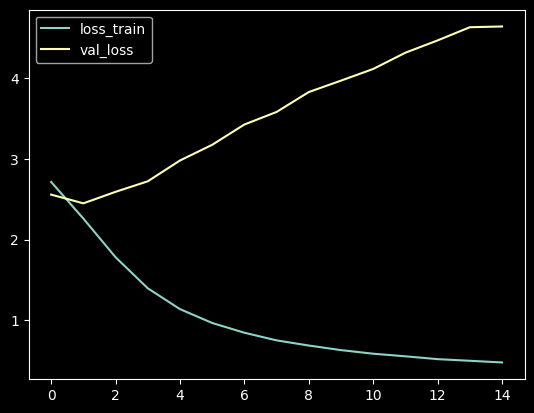

In [43]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')
plt.plot(train_loss)
plt.plot(val_loss)
plt.legend(['loss_train', 'val_loss'])
plt.show()

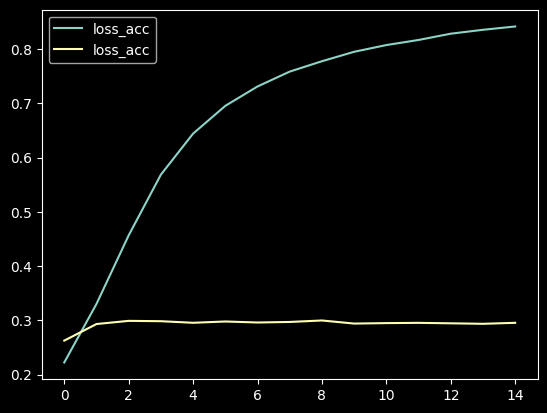

In [44]:
plt.plot(train_acc)
plt.plot(val_acc)
plt.legend(['loss_acc', 'loss_acc'])
plt.show()

In [35]:
checkpoint = torch.load("model_2.pth")
model.load_state_dict(checkpoint['model_state_dict'])
# opt.load_state_dict(checkpoint['optimizer_state_dict'])
# print(checkpoint)


<All keys matched successfully>

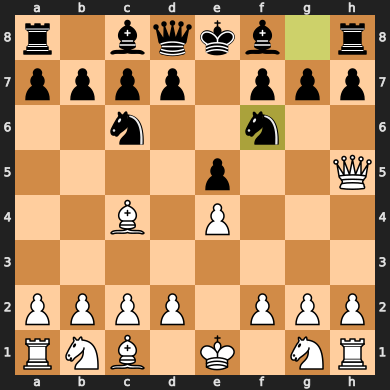

In [36]:
import chess

board = chess.Board()

board.legal_moves
# <LegalMoveGenerator at ... (Nh3, Nf3, Nc3, Na3, h3, g3, f3, e3, d3, c3, ...)>
chess.Move.from_uci("a8a1") in board.legal_moves
# False

board.push_san("e4")
# Move.from_uci('e2e4')
board.push_san("e5")
# Move.from_uci('e7e5')
board.push_san("Qh5")
# Move.from_uci('d1h5')
board.push_san("Nc6")
# Move.from_uci('b8c6')
board.push_san("Bc4")
# Move.from_uci('f1c4')
board.push_san("Nf6")
# Move.from_uci('g8f6')
# board.push_san("Qxf7")
# Move.from_uci('h5f7')
board

In [37]:
new_df = pd.DataFrame({'fen' : [board.fen()], 'move' : ["Qxf7"]})

In [38]:

new_ds = ChessDataset(new_df, board_to_tensor, move_to_index)
new_dl = DataLoader(new_ds, batch_size=1, collate_fn=collate_build_mask)
for planes, targets, legal_mask in new_dl:
    planes = planes.to(device, non_blocking=True).float()
    targets = targets.to(device, non_blocking=True)
    legal_mask = legal_mask.to(device, non_blocking=True)
    logits = model(planes)
    masked_logits = logits.masked_fill(~legal_mask, BIG_NEG)

    # loss = F.cross_entropy(masked_logits, targets)
    # running_val_loss.append(loss.item())
    print(masked_logits.argmax(dim=1))

tensor([690], device='cuda:0')


In [39]:
board.push(chess.Move.from_uci('h5f3'))

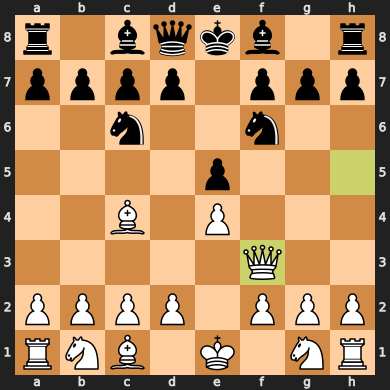

In [45]:
board

In [41]:
test_loop = tqdm(test_loader, leave=False)
running_test_loss = []
correct_top1 = 0
correct_top3 = 0
total = 0
model.eval()
with torch.no_grad():
    for planes, targets, legal_mask in test_loop:
        planes = planes.to(device, non_blocking=True).float()
        targets = targets.to(device, non_blocking=True)
        legal_mask = legal_mask.to(device, non_blocking=True)

        logits = model(planes)
        masked_logits = logits.masked_fill(~legal_mask, BIG_NEG)

        loss = F.cross_entropy(masked_logits, targets)
        running_test_loss.append(loss.item())

        preds = masked_logits.argmax(dim=1)
        correct_top1 += (preds == targets).sum().item()

        # Top-3
        top3_pred = masked_logits.topk(3, dim=1).indices
        correct_top3 += (top3_pred == targets.unsqueeze(1)).any(dim=1).sum().item()

        total += targets.size(0)

mean_test_loss = sum(running_test_loss) / len(running_test_loss)
test_acc_top1 = correct_top1 / total
test_acc_top3 = correct_top3 / total

print(f"Test Loss: {mean_test_loss:.4f}")
print(f"Test Top-1 Accuracy: {test_acc_top1:.4f}")
print(f"Test Top-3 Accuracy: {test_acc_top3:.4f}")

Test Loss: 2.5805
Test Top-1 Accuracy: 0.2990
Test Top-3 Accuracy: 0.5298
